# Exploration

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import math
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold

In [19]:
raw = pd.read_csv("data/Nov2007-June2009.csv").to_numpy()

In [20]:
def clean(raw):
    for i in range(len(raw)):
        for j in range(1,len(raw[0])):
            raw[i][j] = float(raw[i][j].replace(",", ""))
clean(raw)
raw

array([['07/01/2009', 925.03, 931.92, 920.82, 923.33],
       ['06/30/2009', 926.79, 930.01, 912.86, 919.32],
       ['06/29/2009', 916.0, 927.99, 916.18, 927.23],
       ...,
       ['11/05/2007', 1502.17, 1510.84, 1489.95, 1502.17],
       ['11/02/2007', 1509.65, 1513.15, 1492.53, 1509.65],
       ['11/01/2007', 1508.44, 1545.79, 1506.66, 1508.44]], dtype=object)

In [21]:
df = pd.DataFrame(raw, columns=["Date","Open","High","Low","Close"])

In [22]:
def str_to_datetime(s):
    split = s.split('/')
    month, day, year = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(day= day, month=month, year=year)

df["Date"] = df["Date"].apply(str_to_datetime)

In [23]:
def look_back(n, df):
    df = df.drop(["Open", "High", "Low"], axis= 1)
    for i in range(1, n+1):
        df[f"Target-{i}"] = df["Close"].shift(-(i))
    df = df.iloc[:-n , :]
    return df
df = look_back(3, df)
df

,Date,Close,Target-1,Target-2,Target-3
0,2009-07-01,923.33,919.32,927.23,918.9
1,2009-06-30,919.32,927.23,918.9,920.26
2,2009-06-29,927.23,918.9,920.26,900.94
3,2009-06-26,918.9,920.26,900.94,895.1
4,2009-06-25,920.26,900.94,895.1,893.04
...,...,...,...,...,...
411,2007-11-12,1439.18,1453.7,1474.77,1475.62
412,2007-11-09,1453.7,1474.77,1475.62,1520.27
413,2007-11-08,1474.77,1475.62,1520.27,1502.17
414,2007-11-07,1475.62,1520.27,1502.17,1509.65


In [24]:
def window_to_np(dataframe):
    np_df = dataframe.to_numpy()
    # get all the rows but just the first column
    dates = np_df[:, 0]

    input = np_df[:, 2:]
    # 1 bc only one variable
    x = input.reshape((len(dates), input.shape[1], 1))
    # check Y
    y = np_df[:,1]
    return dates, x.astype(np.float32), y.astype(np.float32)

dates, x, y = window_to_np(df)
dates.shape, x.shape, y.shape

((416,), (416, 3, 1), (416,))

<AxesSubplot:xlabel='Date'>

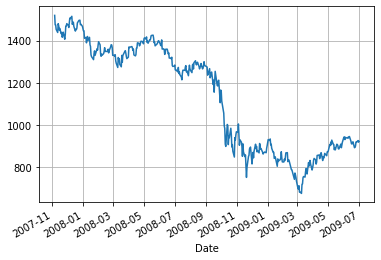

In [25]:
def original(df):
    # remove most left column
    new_df = df.copy()
    new_df.index = new_df.pop("Date")
    # plt.plot(new_df.index, df["Close"])
    # df.index
    original = new_df["Close"].plot()
    plt.grid()
    return original
original(df)

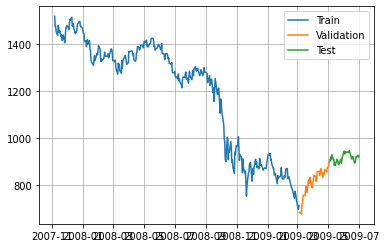

In [28]:
q_10 = int(len(dates) * .1)
q_20 = int(len(dates) * .2)

dates_train, x_train, y_train = dates[q_20:], x[q_20:], y[q_20:]
dates_val, x_val, y_val = dates[q_10:q_20], x[q_10:q_20], y[q_10:q_20]
dates_test, x_test, y_test = dates[:q_10], x[:q_10], y[:q_10]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.grid()

plt.legend(['Train', 'Validation', 'Test'])


In [10]:
# x_train, x_rem, y_train, y_rem, dates_train, dates_rem = train_test_split(x,y, dates, train_size=0.8)
# # Now since we want the valid and test size to be equal (10% each of overall data), we have to define valid_size=0.5 (that is 50% of remaining data)
# x_val, x_test, y_val, y_test, dates_val, dates_test = train_test_split(x_rem,y_rem,dates_rem, test_size=0.5)

In [ ]:
# kfold = KFold(2)
# for train, test in kfold.split(x, y):
def train_model(x_train, y_train, nodes, dropout, learning_rate, batch_size, epochs):
# 3, 1 because 3 days look back and 1 for 1 variable
    model = Sequential([layers.Input((3,1)),
    # the bigger the number, the more complicated, the more likely it is to overfit
                        layers.LSTM(64),
                        layers.Dense(nodes, activation = 'relu'),
                        # randomly choose at this rate certain nodes and don't train them, helps preventoverfitting
                        layers.Dropout(dropout),
                        layers.Dense(nodes, activation = 'relu'),
                        layers.Dropout(dropout),
                        # default is linear
                        layers.Dense(1)])

    model.compile(loss='mse', optimizer=Adam(learning_rate), metrics=['mean_absolute_error'])

    # verbose = 0 means don't print anything
    history = model.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = epochs, batch_size = batch_size, verbose = 0)
    return model, history

In [31]:
least_val_loss = float('inf')
least_loss_model = None
epochs = 1
for nodes in [16, 32, 64]:
    for dropout in [0,0.2]:
        for learning_rate in [0.1, 0.005, 0.001]:
            for batch_size in [16, 32, 64, 128]:
                print(f"nodes = {nodes}, droupout = {dropout}, learning_rate = {learning_rate}, batch_sie = {batch_size}, epochs = {epochs}")
                model, history = train_model(x_train, y_train, nodes, dropout, learning_rate, batch_size, epochs)
                val_loss = model.evaluate(x_val, y_val)

                print("Shape:" , np.shape(val_loss), val_loss)
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model

train_prediction = least_loss_model.predict(x_train).flatten()
plt.plot(dates_train, train_prediction)
plt.plot(dates_train, y_train)
plt.legend(['Train Prediction', 'Actual'])

nodes = 16, droupout = 0, learning_rate = 0.1, batch_sie = 16, epochs = 1
2/2 [==============================] - 0s 2ms/step - loss: 216803.4219 - mean_absolute_error: 462.2530
Shape: (2,) [216803.421875, 462.2530212402344]


TypeError: '<' not supported between instances of 'list' and 'float'

2/2 [==============================] - 0s 4ms/step


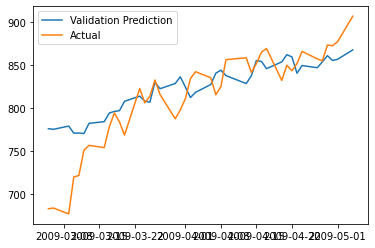

In [ ]:
val_prediction = least_loss_model.predict(x_val).flatten()
plt.plot(dates_val, val_prediction)
plt.plot(dates_val, y_val)
plt.grid()
plt.legend(['Validation Prediction', 'Actual'])

2/2 [==============================] - 0s 4ms/step


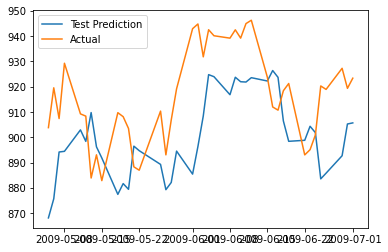

In [ ]:
test_prediction = least_loss_model.predict(x_test).flatten()
plt.plot(dates_test, test_prediction)
plt.plot(dates_test, y_test)
plt.grid()
plt.legend(['Test Prediction', 'Actual'])

In [16]:
plt.plot(dates_train, train_prediction)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_prediction)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_prediction)
plt.plot(dates_test, y_test)
plt.grid()
plt.legend(['Train Prediction', 'Train Actual', 'Validation Prediction', 'Validation Actual', 'Test Prediction', 'Test Actual'])

NameError: name 'train_prediction' is not defined